# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getCloses(names,start,end):
    return web.DataReader(names,'yahoo',start,end)['Adj Close']

In [3]:
names=['AMZN','AAPL','TSLA']
start='2016-03-25'
end='2021-03-24'
data=getCloses(names,start,end)
data.head()

Symbols,AAPL,AMZN,TSLA
Date,,,
2016-03-28,24.459534,579.869995,46.051998
2016-03-29,25.038527,593.859985,46.026001
2016-03-30,25.475679,598.690002,45.377998
2016-03-31,25.343138,593.640015,45.953999
2016-04-01,25.575666,598.500000,47.518002


## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [4]:
R=data.pct_change().dropna()
R.head()

Symbols,AAPL,AMZN,TSLA
Date,,,
2016-03-29,0.023671,0.024126,-0.000565
2016-03-30,0.017459,0.008133,-0.014079
2016-03-31,-0.005203,-0.008435,0.012693
2016-04-01,0.009175,0.008187,0.034034
2016-04-04,0.010274,-0.008872,0.039564


In [7]:
mu=R.mean()
mu

Symbols
AAPL    0.001450
AMZN    0.001502
TSLA    0.002769
dtype: float64

In [8]:
std=R.std()
std

Symbols
AAPL    0.019124
AMZN    0.018555
TSLA    0.037125
dtype: float64

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [9]:
# np.random.randn  -> 365,N
# np.random.normal -> mu,std,size=(365,N)
# N -> Es el número de escenarios
N=100

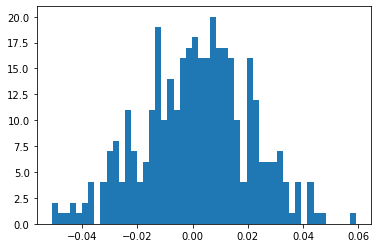

In [12]:
sim=np.random.normal(mu['AAPL'],std['AAPL'],size=365)
H=plt.hist(sim,bins=50)

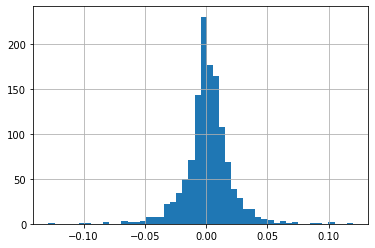

In [13]:
H=R['AAPL'].hist(bins=50)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2018, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2019 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [15]:
#pd.date_range?
pd.date_range('2021-03-25',periods=5)

DatetimeIndex(['2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28',
               '2021-03-29'],
              dtype='datetime64[ns]', freq='D')

In [16]:
def simular(mu,std,start,ndays,N):
    rango=pd.date_range(start,periods=ndays)
    return pd.DataFrame(index=rango,data=np.random.normal(mu,std,size=(ndays,N)))

In [17]:
simAAPL=simular(mu['AAPL'],std['AAPL'],'2021-03-25',365,N)
simAAPL.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-03-25,-0.020161,-0.032006,0.022200,-0.012859,-0.020438,0.006871,0.005582,0.031364,-0.013267,0.007057,...,0.006009,0.005705,0.004046,-0.036414,-0.006352,-0.003357,-0.009568,-0.003758,0.003054,-0.009473
2021-03-26,0.031662,0.019319,0.019251,-0.018409,0.019497,-0.022257,0.000439,0.019028,-0.027064,0.007669,...,-0.008883,0.009921,0.015541,-0.005547,-0.024657,0.008021,0.003310,-0.007580,0.011284,-0.008403
2021-03-27,-0.002517,0.008605,0.017402,-0.002285,-0.017180,0.044833,-0.006649,0.033753,0.001416,-0.025894,...,0.024018,0.008214,0.010752,0.008809,-0.009403,0.047667,-0.016378,-0.000560,-0.004838,0.005291
2021-03-28,-0.015470,0.010727,0.012738,-0.019908,0.007839,-0.011689,0.020832,-0.022973,-0.014974,0.006503,...,-0.030866,-0.011784,0.018136,-0.006565,0.010971,0.015361,0.022859,-0.017099,-0.013206,-0.000399
2021-03-29,0.014692,0.005361,-0.013209,0.002465,0.007193,0.006885,0.035522,-0.016380,-0.010997,0.055630,...,0.000306,0.001351,0.015495,0.020016,-0.010612,-0.000151,0.057833,0.006554,0.025040,-0.001336


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000CEE33C5160>,
      dtype=object)

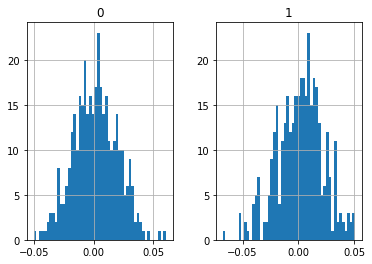

In [20]:
simAAPL[[0,1]].hist(bins=50)

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [21]:
# Producto acumulativo a lo largo de los rengolones
pd.DataFrame.cumprod?

In [22]:
# El último valor conocido
data['AAPL'][-1]

120.08999633789062

In [23]:
data.tail()

Symbols,AAPL,AMZN,TSLA
Date,,,
2021-03-18,120.529999,3027.989990,653.159973
2021-03-19,119.989998,3074.959961,654.869995
2021-03-22,123.389999,3110.870117,670.000000
2021-03-23,122.540001,3137.500000,662.159973
2021-03-24,120.089996,3087.070068,630.270020


In [26]:
AAPL=data['AAPL'][-1]*(simAAPL+1).cumprod()
AAPL.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-03-25,117.668854,116.246409,122.756029,118.545745,117.635591,120.915120,120.760375,123.856504,118.496759,120.937483,...,120.811570,120.775132,120.575836,115.717069,119.327127,119.686818,118.940984,119.638752,120.456708,118.952434
2021-03-26,121.394533,118.492143,125.119173,116.363405,119.929145,118.223955,120.813379,126.213264,115.289802,121.865000,...,119.738400,121.973392,122.449736,115.075164,116.384878,120.646819,119.334735,118.731917,121.815894,117.952849
2021-03-27,121.089004,119.511759,127.296527,116.097528,117.868800,123.524235,120.010058,130.473349,115.453010,118.709390,...,122.614312,122.975335,123.766355,116.088847,115.290502,126.397688,117.380249,118.665485,121.226609,118.576959
2021-03-28,119.215720,120.793740,128.918039,113.786278,118.792785,122.080414,122.510115,127.476026,113.724255,119.481302,...,118.829703,121.526143,126.011018,115.326714,116.555317,128.339223,120.063467,116.636395,119.625661,118.529658
2021-03-29,120.967255,121.441357,127.215194,114.066755,119.647240,122.920885,126.861968,125.388015,112.473651,126.128036,...,118.866030,121.690325,127.963556,117.635040,115.318468,128.319812,127.007093,117.400872,122.621143,118.371347
2021-03-30,121.733046,123.975537,132.885014,112.495520,123.925556,125.598467,126.819001,128.446495,116.182250,122.150348,...,123.325625,115.903247,128.795303,117.795832,115.441690,129.148932,131.438929,115.917894,124.073979,116.818634
2021-03-31,120.847231,122.207838,136.683178,113.367730,121.898425,125.810486,120.557196,131.782544,118.144497,124.489169,...,119.719419,115.471395,131.308982,116.131586,116.384976,127.048199,129.061030,118.581459,123.027895,118.496534
2021-04-01,124.539394,123.084128,138.232424,115.609573,122.145888,128.489606,123.344123,131.422793,120.498126,124.991371,...,120.256617,116.119765,136.022889,119.701136,115.738852,127.275376,127.577777,116.397367,119.330111,118.793257
2021-04-02,124.111713,127.040416,137.999226,116.466692,117.895035,128.751350,126.435288,131.085942,119.840796,126.382772,...,121.747969,115.669650,134.612836,125.971157,116.287354,127.723242,132.176709,115.754123,114.156741,119.422798
2021-04-03,119.702423,125.166900,141.628896,120.417561,116.718740,129.491338,124.734287,132.370125,119.174099,124.137986,...,121.130810,112.951251,134.315311,127.089460,114.321145,127.769391,136.852423,116.604191,115.685408,117.621514


## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [25]:
Umbral=data['AAPL'][-1]*1.2 # Retorno del 20%
Umbral

144.10799560546874

In [30]:
#AAPL.plot(grid=True,legend=False)
rango=pd.date_range('2021-03-25',periods=365)
Umbral_DF=pd.DataFrame(data=np.ones(365)*Umbral,index=rango,columns=['Umbral'])
#Umbral_DF.plot(color='k')
AAPL_Umbral=pd.concat([AAPL,Umbral_DF],axis=1)
AAPL_Umbral.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Umbral
2021-03-25,117.668854,116.246409,122.756029,118.545745,117.635591,120.915120,120.760375,123.856504,118.496759,120.937483,...,120.775132,120.575836,115.717069,119.327127,119.686818,118.940984,119.638752,120.456708,118.952434,144.107996
2021-03-26,121.394533,118.492143,125.119173,116.363405,119.929145,118.223955,120.813379,126.213264,115.289802,121.865000,...,121.973392,122.449736,115.075164,116.384878,120.646819,119.334735,118.731917,121.815894,117.952849,144.107996
2021-03-27,121.089004,119.511759,127.296527,116.097528,117.868800,123.524235,120.010058,130.473349,115.453010,118.709390,...,122.975335,123.766355,116.088847,115.290502,126.397688,117.380249,118.665485,121.226609,118.576959,144.107996
2021-03-28,119.215720,120.793740,128.918039,113.786278,118.792785,122.080414,122.510115,127.476026,113.724255,119.481302,...,121.526143,126.011018,115.326714,116.555317,128.339223,120.063467,116.636395,119.625661,118.529658,144.107996
2021-03-29,120.967255,121.441357,127.215194,114.066755,119.647240,122.920885,126.861968,125.388015,112.473651,126.128036,...,121.690325,127.963556,117.635040,115.318468,128.319812,127.007093,117.400872,122.621143,118.371347,144.107996


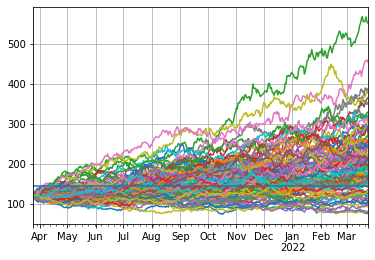

In [32]:
AAPL_Umbral.plot(legend=False,grid=True)

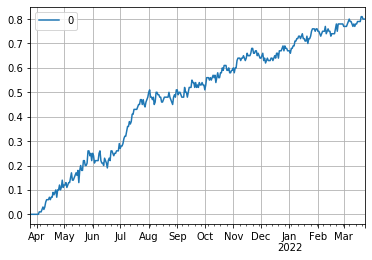

In [34]:
Prob=AAPL>Umbral
pd.DataFrame(data=np.mean(Prob,axis=1)).plot(grid=True)

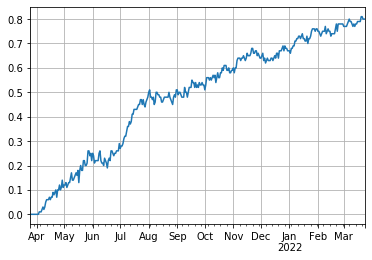

In [35]:
Prob.mean(axis=1).plot(grid=True)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.